<a href="https://colab.research.google.com/github/Apple03244/Colaboratory/blob/main/Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [75]:
import tensorflow.keras as tk
import tensorflow as tf
import pandas as pd
import google.colab as colab

In [ ]:
f=colab.files.upload()

Saving kaggle.json to kaggle.json


In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c titanic

  0% 0.00/34.1k [00:00<?, ?B/s]
100% 34.1k/34.1k [00:00<00:00, 25.3MB/s]


In [ ]:
!unzip /content/titanic.zip

Archive:  /content/titanic.zip
  inflating: gender_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


----

## Data load

In [76]:
train=pd.read_csv("/content/train.csv")
test=pd.read_csv("/content/test.csv")

## model making
- 1. Callbacks
- 2. Tensorboard

### 1. make simple network model

In [77]:
import math as mt

preprocessing

In [78]:
import sklearn.preprocessing as skpre
import sklearn.pipeline as skpip
import sklearn.compose as skcom
import sklearn.impute as skimp
import sklearn.base as skbase
import numpy as np

In [79]:
numeric_pipe=skpip.make_pipeline(skimp.KNNImputer(n_neighbors=10))
category_pipe=skpip.make_pipeline(skimp.SimpleImputer(strategy="most_frequent"),
                                  skpre.OneHotEncoder(drop="first",handle_unknown="ignore"))

class passth(skbase.BaseEstimator,skbase.TransformerMixin):
  def fit(self,X,y=None):
    self.columns=X.columns
    return self
  def transform(self,X):
    return X
  def get_feature_names_out(self):
    return self.columns

preprocess_pipe=skcom.make_column_transformer((numeric_pipe,["Age","SibSp","Parch","Fare"]),
                                              (category_pipe,["Sex","Embarked"]),
                                              (passth(),["Survived","Pclass"]),
                                              remainder="drop")

In [80]:
preprocess_pipe.fit(X=train)

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('knnimputer',
                                                  KNNImputer(n_neighbors=10))]),
                                 ['Age', 'SibSp', 'Parch', 'Fare']),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'))]),
                                 ['Sex', 'Embarked']),
                                ('passth', passth(), ['Survived', 'Pclass'])])

In [81]:
from sys import exec_prefix
pipe_transformers=preprocess_pipe.named_transformers_
column_name=[]
for x in pipe_transformers:
  try:
    column_name.extend(pipe_transformers[x].get_feature_names_out())
  except:
    continue

In [82]:
pred_train=pd.DataFrame(data=preprocess_pipe.transform(train),columns=column_name)

In [83]:
pred_train.head(3)

,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S,Survived,Pclass
0,22.0,1.0,0.0,7.2500,1.0,0.0,1.0,0.0,3.0
1,38.0,1.0,0.0,71.2833,0.0,0.0,0.0,1.0,1.0
2,26.0,0.0,0.0,7.9250,0.0,0.0,1.0,1.0,3.0


make model

In [85]:
# numeric & category
tf.random.set_seed(10)
# input layer
numeric_input=tk.layers.Input(shape=[4])
category_input=tk.layers.Input(shape=[4])

numeric_normalization_layer=tk.layers.Normalization()
numeric_normalization_layer.adapt(pred_train[["Age","SibSp","Parch","Fare"]])

numeric_normalization=numeric_normalization_layer(numeric_input)
numeric_hidden_1=tk.layers.Dense(units=50,activation="relu")(numeric_normalization)
numeric_hidden_2=tk.layers.Dense(units=50,activation="relu")(numeric_hidden_1)
numeric_output=tk.layers.Dense(units=10,activation="linear")(numeric_hidden_2)

category_hidden_1=tk.layers.Dense(units=50,activation="sigmoid")(category_input)
category_hidden_2=tk.layers.Dense(units=50,activation="sigmoid")(category_hidden_1)
category_output=tk.layers.Dense(units=10,activation="sigmoid")(category_hidden_2)

concate=tk.layers.Concatenate()([numeric_output,category_output])
output_hidden=tk.layers.Dense(units=10,activation="sigmoid")(concate)
total_output=tk.layers.Dense(1,activation="sigmoid")(output_hidden)

model=tk.Model(inputs=(numeric_input,category_input),outputs=total_output)

In [86]:
# compile
optimizer=tk.optimizers.Adam(learning_rate=0.01)
loss=tk.losses.BinaryCrossentropy()
metrics=tk.metrics.BinaryAccuracy()
model.compile(optimizer=optimizer,loss=loss,metrics=metrics)

#### 1. Use callback method

- checkpoint : 훈련동안 가장 좋은 모델을 저장함
- early_stoppint : 훈련을 멈춤

이 두 방법을 모두 적용하여 과한 학습을 멈추는게 베스트 -> 학습 부담이 상당히 줄어듬

In [87]:
checkpoint_cb=tk.callbacks.ModelCheckpoint("save_point",save_best_only=True) # monitor : compile 에서 설정된 값을 그대로 가져옴

In [88]:
early_stop_cb=tk.callbacks.EarlyStopping(patience=10,restore_best_weights=True) # restore_best_weight=True 이므로 최고의 모델로 되돌림

In [89]:
history=model.fit(x=(pred_train[["Age","SibSp","Parch","Fare"]],pred_train[["Sex_male","Embarked_Q","Embarked_S","Pclass"]]),
          y=pred_train["Survived"],
          epochs=100,
          callbacks=[checkpoint_cb,early_stop_cb],validation_split=0.2,workers=5,use_multiprocessing=True)

Epoch 1/100
13/23 [===============>..............] - ETA: 0s - loss: 0.6528 - binary_accuracy: 0.6514 

23/23 [==============================] - 4s 102ms/step - loss: 0.6521 - binary_accuracy: 0.6517 - val_loss: 0.5405 - val_binary_accuracy: 0.7542
Epoch 2/100
17/23 [=====================>........] - ETA: 0s - loss: 0.5979 - binary_accuracy: 0.6949

23/23 [==============================] - 3s 121ms/step - loss: 0.5969 - binary_accuracy: 0.6994 - val_loss: 0.5232 - val_binary_accuracy: 0.7542
Epoch 3/100
22/23 [===========================>..] - ETA: 0s - loss: 0.5880 - binary_accuracy: 0.7102

23/23 [==============================] - 3s 117ms/step - loss: 0.5892 - binary_accuracy: 0.7093 - val_loss: 0.5126 - val_binary_accuracy: 0.7709
Epoch 4/100
23/23 [==============================] - 0s 6ms/step - loss: 0.5750 - binary_accuracy: 0.7219 - val_loss: 0.5260 - val_binary_accuracy: 0.7709
Epoch 5/100
15/23 [==================>...........] - ETA: 0s - loss: 0.5548 - binary_accuracy: 0.7417

23/23 [==============================] - 3s 115ms/step - loss: 0.5484 - binary_accuracy: 0.7430 - val_loss: 0.4461 - val_binary_accuracy: 0.7877
Epoch 6/100
14/23 [=================>............] - ETA: 0s - loss: 0.4921 - binary_accuracy: 0.7835

23/23 [==============================] - 2s 88ms/step - loss: 0.4925 - binary_accuracy: 0.7739 - val_loss: 0.3864 - val_binary_accuracy: 0.8659
Epoch 7/100
12/23 [==============>...............] - ETA: 0s - loss: 0.4411 - binary_accuracy: 0.8203

23/23 [==============================] - 2s 88ms/step - loss: 0.4608 - binary_accuracy: 0.8020 - val_loss: 0.3648 - val_binary_accuracy: 0.8603
Epoch 8/100
23/23 [==============================] - 0s 7ms/step - loss: 0.4552 - binary_accuracy: 0.8006 - val_loss: 0.3946 - val_binary_accuracy: 0.8547
Epoch 9/100
12/23 [==============>...............] - ETA: 0s - loss: 0.4590 - binary_accuracy: 0.8125

23/23 [==============================] - 2s 88ms/step - loss: 0.4485 - binary_accuracy: 0.8104 - val_loss: 0.3638 - val_binary_accuracy: 0.8547
Epoch 10/100
23/23 [==============================] - 0s 6ms/step - loss: 0.4399 - binary_accuracy: 0.8020 - val_loss: 0.3807 - val_binary_accuracy: 0.8547
Epoch 11/100
15/23 [==================>...........] - ETA: 0s - loss: 0.4318 - binary_accuracy: 0.8271

23/23 [==============================] - 3s 115ms/step - loss: 0.4298 - binary_accuracy: 0.8244 - val_loss: 0.3573 - val_binary_accuracy: 0.8547
Epoch 12/100
23/23 [==============================] - 0s 8ms/step - loss: 0.4418 - binary_accuracy: 0.8202 - val_loss: 0.3616 - val_binary_accuracy: 0.8603
Epoch 13/100
23/23 [==============================] - 0s 9ms/step - loss: 0.4320 - binary_accuracy: 0.8188 - val_loss: 0.3823 - val_binary_accuracy: 0.8492
Epoch 14/100
23/23 [==============================] - 0s 10ms/step - loss: 0.4424 - binary_accuracy: 0.8132 - val_loss: 0.3850 - val_binary_accuracy: 0.8492
Epoch 15/100
20/23 [=========================>....] - ETA: 0s - loss: 0.4317 - binary_accuracy: 0.8125

23/23 [==============================] - 3s 150ms/step - loss: 0.4408 - binary_accuracy: 0.8118 - val_loss: 0.3522 - val_binary_accuracy: 0.8436
Epoch 16/100
14/23 [=================>............] - ETA: 0s - loss: 0.4300 - binary_accuracy: 0.8103

23/23 [==============================] - 2s 90ms/step - loss: 0.4215 - binary_accuracy: 0.8188 - val_loss: 0.3520 - val_binary_accuracy: 0.8659
Epoch 17/100
23/23 [==============================] - 0s 7ms/step - loss: 0.4171 - binary_accuracy: 0.8287 - val_loss: 0.3603 - val_binary_accuracy: 0.8659
Epoch 18/100
23/23 [==============================] - 0s 7ms/step - loss: 0.4144 - binary_accuracy: 0.8244 - val_loss: 0.3635 - val_binary_accuracy: 0.8380
Epoch 19/100
23/23 [==============================] - 0s 6ms/step - loss: 0.4014 - binary_accuracy: 0.8244 - val_loss: 0.4122 - val_binary_accuracy: 0.8380
Epoch 20/100
23/23 [==============================] - 0s 6ms/step - loss: 0.4286 - binary_accuracy: 0.8287 - val_loss: 0.3758 - val_binary_accuracy: 0.8436
Epoch 21/100
15/23 [==================>...........] - ETA: 0s - loss: 0.3934 - binary_accuracy: 0.8250

23/23 [==============================] - 2s 88ms/step - loss: 0.4061 - binary_accuracy: 0.8174 - val_loss: 0.3439 - val_binary_accuracy: 0.8603
Epoch 22/100
23/23 [==============================] - 0s 6ms/step - loss: 0.4028 - binary_accuracy: 0.8160 - val_loss: 0.3611 - val_binary_accuracy: 0.8492
Epoch 23/100
23/23 [==============================] - 0s 7ms/step - loss: 0.3999 - binary_accuracy: 0.8216 - val_loss: 0.3456 - val_binary_accuracy: 0.8380
Epoch 24/100
23/23 [==============================] - 0s 5ms/step - loss: 0.3933 - binary_accuracy: 0.8329 - val_loss: 0.3570 - val_binary_accuracy: 0.8324
Epoch 25/100
23/23 [==============================] - 0s 6ms/step - loss: 0.4034 - binary_accuracy: 0.8202 - val_loss: 0.3510 - val_binary_accuracy: 0.8380
Epoch 26/100
23/23 [==============================] - 0s 6ms/step - loss: 0.4080 - binary_accuracy: 0.8357 - val_loss: 0.3644 - val_binary_accuracy: 0.8492
Epoch 27/100
23/23 [==============================] - 0s 6ms/step - loss: 0.

In [90]:
history_datas=pd.DataFrame(history.history)

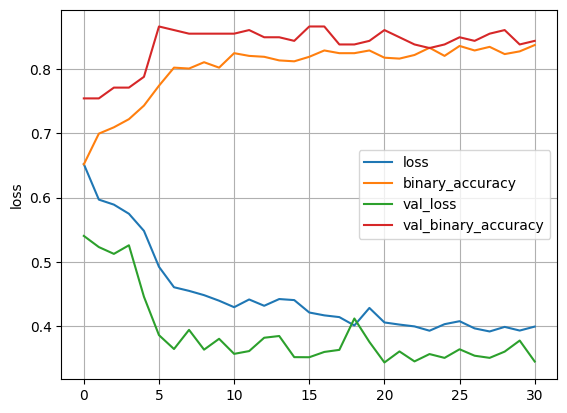

In [91]:
import matplotlib.pyplot as plt
import seaborn as sb
plt.figure()
for col in history_datas.columns:
  sb.lineplot(x=history_datas.index,y=history_datas[col],label=col)
plt.grid()
plt.show()

In [92]:
submission=pd.read_csv("/content/gender_submission.csv")

In [93]:
test_data=pd.merge(test,submission,left_on=["PassengerId"],right_on=["PassengerId"])

In [94]:
preprocess_pipe.fit(test_data)
column_name=[]
for x in preprocess_pipe.named_transformers_:
  try:
    column_name.extend(preprocess_pipe.named_transformers_[x].get_feature_names_out())
  except:
    continue

In [95]:
pre_test_data=pd.DataFrame(preprocess_pipe.transform(test_data),columns=column_name)

In [96]:
pre_test_data.head(3)

,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S,Survived,Pclass
0,34.5,0.0,0.0,7.8292,1.0,1.0,0.0,0.0,3.0
1,47.0,1.0,0.0,7.0000,0.0,0.0,1.0,1.0,3.0
2,62.0,0.0,0.0,9.6875,1.0,1.0,0.0,0.0,2.0


In [98]:
model.evaluate(x=(pre_test_data[["Age","SibSp","Parch","Fare"]],pre_test_data[["Sex_male","Embarked_Q","Embarked_S","Pclass"]]),
               y=pre_test_data["Survived"],
               return_dict=True)

14/14 [==============================] - 0s 5ms/step - loss: 0.2945 - binary_accuracy: 0.9019


{'loss': 0.29451075196266174, 'binary_accuracy': 0.9019138813018799}

In [103]:
predict_dataset=pd.DataFrame(model.predict(x=(pre_test_data[["Age","SibSp","Parch","Fare"]],pre_test_data[["Sex_male","Embarked_Q","Embarked_S","Pclass"]]))
,columns=["predict_proba"])

14/14 [==============================] - 0s 6ms/step


In [105]:
predict_dataset['predict']=predict_dataset.applymap(lambda x:0 if x<0.5 else 1)

#### Confusion matrix

In [107]:
import sk

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,1
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,1
...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S,0
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C,1
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S,0
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S,0
